In [2]:
#################################################
# SOLVENTS Dried PPM by Lot Number Last 2 Months
# TO DO SEPERATE FOR EACH SOLVENT - (DONE)
# SPLIT OUT DRIED AND RECEIVED (DONE)
# UPPER CONTROL LIMIT AND LCL IN BLACK LINE (DONE)
# SPECLIMIT IN RED LINE (DONE)
# ORDER BY LN AFTER DASH (DONE)
# SOLVENTS = XYLENE (done), IBIB, EP (DONE)
# POWDERS = 'LB', 'LC', ('LI', 'LL') (DONE)
#################################################

import sqlalchemy as sa
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sqlalchemy
import pyodbc
import pymssql
import plotly.express as px
from matplotlib.lines import Line2D  

%matplotlib inline

username = "superuser"
pw = "90rl()RL"
db = "SP_ManuLine"
port = "1433"
server = "192.168.14.119"

In [13]:

def graphIngredients():
    
    cnxn = pymssql.connect(server=server, user=username, password=pw, database=db)
    cursor = cnxn.cursor(as_dict=True)

    debug = 0        # 1 = print to screen | 0 = no print to screen
    specx, specy = '', ''
    
    # SOLVENTS = XY, IB, EP
    # POWDERS = LB, LC, (LI, LL)

    #ingredient = 'EP'
    ingredient = input("Enter Ingredient (XY, IB, EP, LB, LC, (LI, LL)) (ENTER for XYLENES): ") or 'XY'
    ingredient = ingredient.upper()
    
    #moisture: 00=dried 19=as received
    moisture = input("Enter DRIED (00) or AS RECEIVED (19) (ENTER for DRIED): ") or str('00')
    #months = -2
    months = input("Enter Months back to analyze (ENTER for 2 Months):") or str(2)
    months = "-" + str(months)

    #if debug == 1:
       #print(months)

    PPMQuery = "select avgKSolidMoisture_ppm, d.* \
                            from dbo.drying d cross join (\
                                select avg(KSolidMoisture_ppm) avgKSolidMoisture_ppm \
                                from dbo.drying \
                                where substring(partnr, 1,2) in ('" + ingredient + "') \
                                and entrydate >= dateadd(month, " + str(months) + ", getdate()) \
                                and substring(productpn, 9,2) = '" + moisture + "' \
                                ) a \
                            where substring(partnr, 1,2) in ('" + ingredient + "') \
                            and entrydate >= dateadd(month, " + str(months) + ", getdate()) \
                            and substring(productpn, 9,2) = '" + moisture + "' \
                            order by substring(ingredientln, 4, 4) desc"
                            #order by entrydate desc"

    if debug == 1:
        print("--------------------------------------------------------")
        print(PPMQuery)

    cursor.execute(PPMQuery)

    df = pd.read_sql(PPMQuery, cnxn )

    x = df.IngredientLN
    y = df.KSolidMoisture_ppm
    avg = df.avgKSolidMoisture_ppm
    #avg = np.mean(df.KSolidMoisture_ppm)

    if debug == 1:
        print("--------------------------------------------------------")
        print("Average PPM: " + str(np.mean(avg)))
        print("Ingredient:  " + str(ingredient))
        print("Dried/As Received:  " + str(moisture))

    plt.figure(figsize=(20,10))
    colors = np.random.rand(50)
    
    # SOLVENT DRIED ##############################################################################################################
    if ingredient == "XY" and moisture == str("00"):
        message = "XYLENE solvent DRIED PPM by Lot Number Last " + str(abs(int(months))) + " Months"
        specx, specy = [0,len(df)-1], [10,10]
        upperx, uppery = [0, len(df)-1], [17.61, 17.61]
        lowerx, lowery = [0, len(df)-1], [3.26, 3.26]
    elif ingredient == "IB" and moisture == str("00"):
        message = "ISOBUTYL ISOBUTYRATE (IBIB) solvent DRIED PPM by Lot Number Last " + str(abs(int(months))) + " Months"
        specx, specy = [0,len(df)-1], [20,20]
        upperx, uppery = [0, len(df)-1], [32.08, 32.08]
        lowerx, lowery = [0, len(df)-1], [4.06, 4.06]
    elif ingredient == "EP" and moisture == str("00"):
        message = "ETHYL PROPIONATE solvent DRIED PPM by Lot Number Last " + str(abs(int(months))) + " Months"
        specx, specy = [0,len(df)-1], [10,10]
        upperx, uppery = [0, len(df)-1], [65.3, 65.3]
        lowerx, lowery = [0, len(df)-1], [0, 0]
        
    # SOLVENT AS RECEIVED ##############################################################################################################
    elif ingredient == "XY" and moisture == str("19"):
        message = "XYLENE solvent AS RECEIVED PPM by Lot Number Last " + str(abs(int(months))) + " Months"
    elif ingredient == "IB" and moisture == "19":
        message = "ISOBUTYL ISOBUTYRATE (IBIB) solvent AS RECEIVED PPM by Lot Number Last " + str(abs(int(months))) + " Months"
    elif ingredient == "EP" and moisture == "19":
        message = "ETHYL PROPIONATE solvent AS RECEIVED PPM by Lot Number Last " + str(abs(int(months))) + " Months"

    # POWDER DRIED LB, LC, (LI, LL) ##############################################################################################################
    elif ingredient == "LB" and moisture == "00":
        message = "LITHIUM BROMIDE powder DRIED PPM by Lot Number Last " + str(abs(int(months))) + " Months"
        specx, specy = [0,len(df)-1], [30,30]
        upperx, uppery = [0, len(df)-1], [73.5, 73.5]
        lowerx, lowery = [0, len(df)-1], [0, 0]
    elif ingredient == "LC" and moisture == "00":
        message = "LITHIUM CHLORIDE powder DRIED PPM by Lot Number Last " + str(abs(int(months))) + " Months"
        specx, specy = [0,len(df)-1], [120,120]
        upperx, uppery = [0, len(df)-1], [32.3, 32.3]
        lowerx, lowery = [0, len(df)-1], [0, 0]
    elif ( ingredient in ( "LI", "LL") ) and moisture == "00":
        message = "LITHIUM IODIDE powder DRIED PPM by Lot Number Last " + str(abs(int(months))) + " Months"
        specx, specy = [0,len(df)-1], [300,300]
        
    # POWDER AS RECEIVED ##############################################################################################################    
    elif ingredient == "LB" and moisture == "19":
        message = "LITHIUM BROMIDE powder AS RECEIVED PPM by Lot Number Last " + str(abs(int(months))) + " Months"
    elif ingredient == "LC" and moisture == "19":
        message = "LITHIUM CHLORIDE powder AS RECEIVED PPM by Lot Number Last " + str(abs(int(months))) + " Months"
    elif ( ingredient == "LI" or ingredient == "LL" ) and moisture == "19":
        message = "LITHIUM IODIDE powder AS RECEIVED PPM by Lot Number Last " + str(abs(int(months))) + " Months"

    if debug == 1:
        print("TITLE:  " + message)
        
    plt.title(message, fontsize=18, color="blue")
    plt.xlabel('Ingredient LN')
    plt.ylabel('K Solid Moisture PPM')

    # PLOT FOR THE AVERAGE LINE
    plt.plot(x, avg, "-", color="green")
    
    # PLOT FOR THE SPEC LINE
    if specx != '' and specy != '':
        plt.plot(specx, specy, "-", color="red")
    
    # PLOT FOR UPPER AND LOWER CONTROL LIMIT
    if moisture == '00' and ingredient not in ('LI', 'LL'):
        plt.plot(upperx, uppery, "--", color = "black")
        plt.plot(lowerx, lowery, "--", color = "black")
        
    # PLOT THE SCATTER PLOT FOR THE LOT NUMBERS
    plt.scatter(x, y, alpha=0.99)
    
    #plt.legend()
    plt.show()

    cnxn.close()
    print("DONE!")

Enter Ingredient (XY, IB, EP, LB, LC, (LI, LL)) (ENTER for XYLENES):  
Enter DRIED (00) or AS RECEIVED (19) (ENTER for DRIED):  
Enter Months back to analyze (ENTER for 2 Months): 


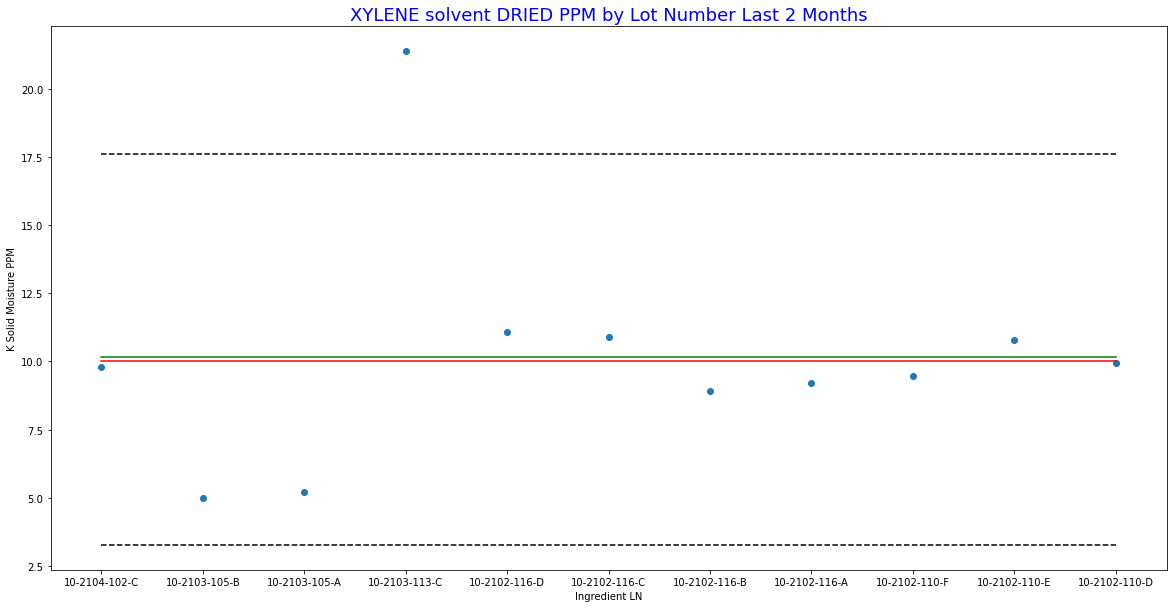

DONE!


In [16]:
graphIngredients()
#cnxn.close()

Enter Ingredient (XY, IB, EP, LB, LC, (LI, LL)) (ENTER for XYLENES):  
Enter DRIED (00) or AS RECEIVED (19) (ENTER for DRIED):  
Enter Months back to analyze (ENTER for 2 Months): 


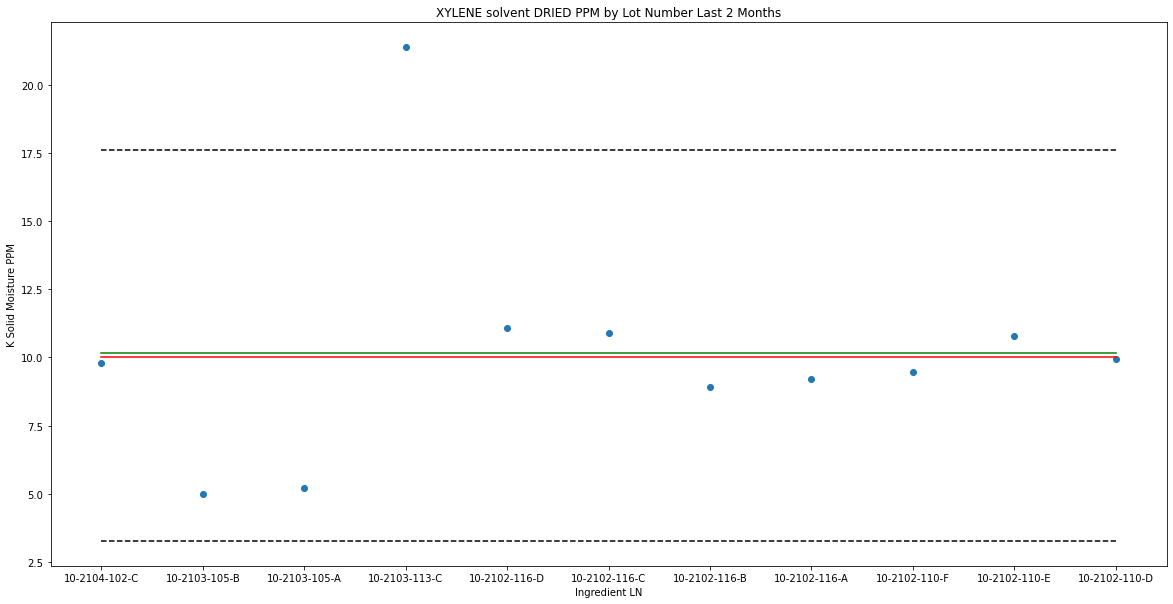

In [5]:
graphIngredients()
#cnxn.close()

In [ ]:
#####################################################################
# ALL SOLVENTS Dried PPM by Lot Number Last 2 Months for ALL SOLVENTS
#####################################################################
cnxn = pymssql.connect(server=server, user=username, password=pw, database=db)
cursor = cnxn.cursor(as_dict=True)

debug = 1 # 1 = no print

# SOLVENTS = XY, IB, EP
# POWDERS = LB, LC, (LI, LL)

#ingredient = 'EP'
ingredient = input("Enter Ingredient (XY, IB, EP, LB, LC, (LI, LL)) (ENTER for XYLENES): ") or 'XY'
#moisture = '19'  # 00=dried 19=as received
moisture = input("Enter DRIED (00) or AS RECEIVED (19) (ENTER for DRIED): ") or str('00')
#months = -2
months = input("Enter Months back to analyze (ENTER for 2 Months):") or str(2)
months = "-" + str(months)

if debug == 1:
    print(months)

PPMQuery = "select avgKSolidMoisture_ppm, d.* \
                        from dbo.drying d cross join (\
                            select avg(KSolidMoisture_ppm) avgKSolidMoisture_ppm \
                            from dbo.drying \
                            where substring(partnr, 1,2) in ('" + ingredient + "') \
                            and entrydate >= dateadd(month, " + str(months) + ", getdate()) \
                            and substring(productpn, 9,2) = '" + moisture + "' \
                            ) a \
                        where substring(partnr, 1,2) in ('" + ingredient + "') \
                        and entrydate >= dateadd(month, " + str(months) + ", getdate()) \
                        and substring(productpn, 9,2) = '" + moisture + "' \
                        order by substring(ingredientln, 4, 4) desc"
                        #order by entrydate desc"

if debug == 1:
    print(PPMQuery)

cursor.execute(PPMQuery)

df = pd.read_sql(PPMQuery, cnxn )

x = df.IngredientLN
y = df.KSolidMoisture_ppm
avg = df.avgKSolidMoisture_ppm
#avg = np.mean(df.KSolidMoisture_ppm)

if debug == 1:
    print(np.mean(avg))

plt.figure(figsize=(20,10))
colors = np.random.rand(50)

# SOLVENT DRIED
if ingredient == "XY" and moisture == "00":
    message = "XYLENE solvent DRIED PPM by Lot Number Last " + str(abs(int(months))) + " Months"
elif ingredient == "IB" and moisture == "00":
    message = "ISOBUTYL ISOBUTYRATE (IBIB) solvent DRIED PPM by Lot Number Last " + str(abs(int(months))) + " Months"
elif ingredient == "EP" and moisture == "00":
    message = "ETHYL PROPIONATE solvent DRIED PPM by Lot Number Last " + str(abs(int(months))) + " Months"
# SOLVENT AS RECEIVED    
elif ingredient == "XY" and moisture == "19":
    message = "XYLENE solvent AS RECEIVED PPM by Lot Number Last " + str(abs(int(months))) + " Months"
elif ingredient == "IB" and moisture == "19":
    message = "ISOBUTYL ISOBUTYRATE (IBIB) solvent AS RECEIVED PPM by Lot Number Last " + str(abs(int(months))) + " Months"
elif ingredient == "EP" and moisture == "19":
    message = "ETHYL PROPIONATE solvent AS RECEIVED PPM by Lot Number Last " + str(abs(int(months))) + " Months"
    
# POWDER DRIED LB, LC, (LI, LL)
elif ingredient == "LB" and moisture == "00":
    message = "LITHIUM BROMIDE powder DRIED PPM by Lot Number Last " + str(abs(int(months))) + " Months"
elif ingredient == "LC" and moisture == "00":
    message = "LITHIUM CHLORIDE ISOBUTYRATE (IBIB) powder DRIED PPM by Lot Number Last " + str(abs(int(months))) + " Months"
elif ( ingredient == "LI" or ingredient == "LL" ) and moisture == "00":
    message = "LITHIUM IODIDE powder DRIED PPM by Lot Number Last " + str(abs(int(months))) + " Months"
# SOLVENT AS RECEIVED    
elif ingredient == "LB" and moisture == "19":
    message = "LITHIUM BROMIDE powder AS RECEIVED PPM by Lot Number Last " + str(abs(int(months))) + " Months"
elif ingredient == "LC" and moisture == "19":
    message = "LITHIUM CHLORIDE ISOBUTYRATE (IBIB) powder AS RECEIVED PPM by Lot Number Last " + str(abs(int(months))) + " Months"
elif ( ingredient == "LI" or ingredient == "LL" ) and moisture == "19":
    message = "LITHIUM IODIDE powder AS RECEIVED PPM by Lot Number Last " + str(abs(int(months))) + " Months"
    
plt.title(message)
plt.xlabel('Ingredient LN')
plt.ylabel('K Solid Moisture PPM')

#plt.Line2D(xdata=x, ydata=avg)
plt.plot(x, avg, "-", color="green")

plt.scatter(x, y, alpha=0.99)
plt.show()

cnxn.close()